# Y. Xu. Alternating proximal gradient method for sparse nonnegative Tucker decomposition. Mathematical Programming Computation, 7(1), 39–70, 2015

#### Ссылка на публикацию в журнале: https://link.springer.com/article/10.1007/s12532-014-0074-y

#### Ссылка на страницу в Google Scholar: https://scholar.google.ru/scholar?cluster=3616507962580648378&hl=ru&as_sdt=0,5

#### Ссылка на статью в arXiv: https://arxiv.org/abs/1302.2559

Личная старница автора: https://xu-yangyang.github.io/

Исходный код (Matlab): https://xu-yangyang.github.io/codes/apg-ntd.zip

Данные "Swimmers": https://web.stanford.edu/~vcs/Data/Y.mat

## Дополнительные ресурсы:

#### Proximal algorithms: https://web.stanford.edu/~boyd/papers/prox_algs.html

## Краткое содержание статьи (3-10 предложений)

В статье предложен алгоритм proximal ALS вычисления параметров разложения Таккера с условиями разреженности и неотрицательности. Рассмотрена модификация алгоритма для данных с пропусками, проведён анализ сходимости и вычислительной сложности метода, показаны условия глобальной сходиомсти. Проведены численные эксперименты на искуственных и реальных данных. Исходный код и демонстрационный материал на языке Matlab доступны на личной странице автора.

## Презентация материалов статьи

### Постановка задачи

Оптимизационная задача:

$$\min_{G, A_i} \frac{1}{2}\||[G; A_1, \ldots, A_d]| - T\|^2_F + \lambda_G \|G\|_1 + \sum\limits_{i=1}^d \lambda_{i} \|A_i\|_1, \\
s.t. G \in \mathbb{R}_{\geq 0}^{r_1 \times \ldots \times r_d}, \, A_i \in \mathbb{R}_{\geq 0}^{n_i \times r_i}, \, i = \overline{1, d}$$

$\lambda_G$, $\lambda_i$ - параметры, регулирующие разреженность

$(r_1, \ldots, r_d)$ - ранг разложения Таккера

Метод оптимизации: proximal ALS

Особенность предложенного подхода - $G$ обновляется сразу после обновления $A_i$.

### Proximal operator

$$\text{prox}_{\lambda f} (v) = \arg\min\limits_{x} \big( f(x) + \frac{1}{2 \lambda}\|x-v\|_2^2\big), \quad \lambda > 0$$

Можно применять стандартные методы для решения задачи с таким оператором, но часто можно получить аналитическую формулу или алгоритм обновления за линейное время.

Обладает свойством блочного разделения:

$$ f(x) = f_1(x) + \ldots + f_n(x) \implies (\text{prox}_{\lambda f} (v))_i = \text{prox}_{\lambda f_i} (v_i)$$

Точка $x^*$ является неподвижной точкой оператора близости $\iff$ $x^*$ - точка минимума $f$.

$$x_{k+1} = \text{prox}_{\lambda f} (x_k)$$

### Proximal ALS

$$G_{k+1} = \arg\min\limits_{G \geq 0} \Big( \nabla_G l\big(G_k, (A_1)_k, \ldots, (A_d)_k\big), G - \hat{G} \Big)_{F} + \frac{L_G}{2} \|G - \hat{G}\|_F^2 + \lambda_G \|G\|_1 = $$
$$ = \max\Big( 0, \, \hat{G} - \frac{1}{L_G} \nabla_G l\big(G_k, (A_1)_k, \ldots, (A_d)_k\big) - \frac{\lambda_G}{L_G} \Big)$$

$$(A_i)_{k+1} = \arg\min\limits_{A_i \geq 0} \Big( \nabla_{A_i} l\big(G_k, (A_1)_{k+1}, \ldots, (A_{i-1})_{k+1}, \hat{A}_i, (A_{i+1})_k, \ldots, (A_d)_k\big), A_i - \hat{A}_i \Big)_{F} + \frac{L_G}{2} \|A_i - \hat{A}_i\|_F^2 + \lambda_{A_i} \|A_i\|_1 = $$
$$ = \max\Big( 0, \, \hat{A}_i - \frac{1}{L_{A_i}} \nabla_{A_i} l\big(G_k, (A_1)_{k+1}, \ldots, (A_{i-1})_{k+1}, \hat{A}_i, (A_{i+1})_k, \ldots, (A_d)_k\big) - \frac{\lambda_{A_i}}{L_{A_i}} \Big)$$

$L_G, L_{A_i}$  - Липшицевы константы для градиентов по $G$, $A_i$.

$$L_{G_{k+1; i}} = \max\big(1, \|(A_d)_{k}^T (A_d)_{k} \otimes \ldots \otimes (A_{i+1})_{k}^T (A_{i+1})_{k} \otimes (A_{i})_{k+1}^T (A_{i})_{k+1} \otimes \ldots \otimes (A_{1})_{k+1}^T (A_{1})_{k+1} \|\big)$$

$$L_{(A_i); {k+1}} = \max\big(1, \| (B_{k+1; i})_{(i)} (B_{k+1; i})_{(i)}^T \| \big), \quad B_{k+1; i} = |[G_{k+1; i}; (A_{1})_{k+1}, \ldots, (A_{i-1})_{k+1}, (A_{i})_{k}, \ldots, (A_{d})_{k}]|$$

In [1]:

# загрузка необходимых библиотек
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
import scipy.io as spio
%matplotlib inline

In [2]:
# thanks to http://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict   

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        elif isinstance(elem,np.ndarray):
            dict[strg] = _tolist(elem)
        else:
            dict[strg] = elem
    return dict

def _tolist(ndarray):
    '''
    A recursive function which constructs lists from cellarrays 
    (which are loaded as numpy ndarrays), recursing into the elements
    if they contain matobjects.
    '''
    elem_list = []            
    for sub_elem in ndarray:
        if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
            elem_list.append(_todict(sub_elem))
        elif isinstance(sub_elem,np.ndarray):
            elem_list.append(_tolist(sub_elem))
        else:
            elem_list.append(sub_elem)
    return elem_list

In [3]:
# общие функции, облегчающие реализацию разложения

def vec(x):
    return x.flatten(order='F')

def reshape(a, shape):
    return np.reshape(a, shape, order = 'F')

def unfold(x, mode, return_sigma=False, reverse=False):
    n = x.shape
    d = x.ndim
    if not reverse:
        sigma = [mode] + range(mode) + range(mode+1, d)
    else:
        sigma = [mode] + range(d-1, mode, -1) + range(mode-1, -1, -1)
    tmp = np.transpose(x, sigma)
    tmp = reshape(tmp, [n[mode], -1])
    if return_sigma:
        return tmp, sigma
    return tmp

def prodTenMat(T, M, mode_t, mode_m=1):
    assert M.ndim == 2, "Second operand must be a matrix"
    subT = range(T.ndim)
    subR = range(T.ndim)
    subR[mode_t] = T.ndim
    subM = [T.ndim, T.ndim]
    subM[mode_m] = subT[mode_t]
    result = np.einsum(T, subT, M, subM, subR)
    return result

def fast_svd(x, R=None, tol=None, scale=1.5):
    [m, n] = x.shape
    if m >= scale*n:
        tmp = np.dot(x.T, x)
        _, s, vt = np.linalg.svd(tmp)
        if tol is not None:
            csumdiff = np.diff(_np.cumsum(s))
            Rtol = csumdiff[csumdiff >= tol].sum()
        if R is not None:
            Rs = R
            if tol is not None:
                Rs = min(Rtol, Rs)
            s = s[:Rs]
            vt = vt[:Rs, :]
        s = s**0.5
        u = np.dot(x, (vt.T / s))
    elif n >= scale*m:
        tmp = np.dot(x, x.T)
        u, s, _ = np.linalg.svd(tmp)
        if tol is not None:
            csumdiff = _np.diff(np.cumsum(s))
            Rtol = csumdiff[csumdiff >= tol].sum()
        if R is not None:
            Rs = R
            if tol is not None:
                Rs = min(Rtol, Rs)
            s = s[:Rs]
            u = u[:, :Rs]
        s = s**0.5
        vt = np.dot(u.T, x).T / s
    else:
        u, s, vt = np.linalg.svd(x)
        if tol is not None:
            csumdiff = np.diff(np.cumsum(s**2.))
            Rtol = csumdiff[csumdiff >= tol].sum()
        if R is not None:
            Rs = R
            if tol is not None:
                Rs = min(Rtol, Rs)
            u = u[:, :Rs]
            s = s[:Rs]
            vt = vt[:Rs, :]
    return u, s, vt

In [4]:
def initialize(n, r, margin=0.):
    d = len(n)
    G = np.random.normal(size=r)
    G = np.maximum(G, margin)
    G /= np.linalg.norm(G)
    A = [None]*d
    for i in xrange(d):
        tmp = np.random.normal(size=[n[i], r[i]])
        A[i] = np.maximum(tmp, margin)
        A[i] /= np.linalg.norm(A[i], axis=0, keepdims=True)
    return A, G

def hosvd(T, A, G, eps=0.):
    d = T.ndim
    r = G.shape
    A0 = [None]*d
    G0 = T.copy()
    for k in xrange(d):
        tmp = T.copy()
        for i in xrange(d):
            if i != k:
                tmp = prodTenMat(tmp, A[i].T, i)
        #tmp = nvecs({'G': tmp, }, k, r[k])
        tmp = unfold(tmp, k)
        tmp = np.dot(tmp, tmp.T)
        tmp, _, _ = np.linalg.svd(tmp)
        tmp = tmp[:, :r[k]]
        A0[k] = np.maximum(tmp, eps)
        A0[k] /= np.sum(A0[k], axis=0, keepdims=True)
        G0 = prodTenMat(G0, A0[k].T, k)
    return A0, G0

In [7]:
# реализация разложения

def recover(A, G, exclude_modes=[]):
    d = len(A)
    assert G.ndim == d
    rv = G.copy()
    for k in xrange(d):
        if k in exclude_modes:
            continue
        rv = prodTenMat(rv, A[k], k)
    return rv
    
    
def functional(k, T, A, G, Lambda, AtA, exclude_modes, separate=False):
    # NNLS part
    normT = np.linalg.norm(T)
    d = T.ndim
    partTuck = G.copy()
    partTD = T.copy()
    for k in xrange(d):
        if k in exclude_modes:
            continue
        partTuck = prodTenMat(partTuck, AtA[k], k)
        partTD = prodTenMat(partTD, A[k].T, k)
    axes = range(d)
    rv = np.einsum(partTuck - 2*partTD, axes, G, axes)
    rv = 0.5*(normT**2. + rv)
    # sparse part
    tmp = set(range(d)).difference(set(exclude_modes))
    tmp = np.array(list(tmp))
    nrms1 = [np.linalg.norm(vec(G), 1)]
    nrms1 = [np.linalg.norm(vec(A[k]), 1) for k in tmp] + nrms1
    if separate:
        return rv, np.array(nrms1)[tmp]*Lambda[tmp]
    rv += np.sum(np.array(nrms1)[tmp]*Lambda[tmp])
    return rv

def update_L_factor(k, AtA, G, exclude_modes=[]):
    d = len(AtA)
    tmp = G.copy()
    for p in xrange(d):
        if (p == k) or (p in exclude_modes):
            continue
        tmp = prodTenMat(tmp, AtA[p], p)
    axes1 = range(d)
    axes1[k] = d+k
    axes2 = range(d)
    axes2[k] = d+k+1
    tmp = np.einsum(tmp, axes1, G, axes2)
    #L = np.linalg.norm(tmp, ntype)
    _, s, _ = np.linalg.svd(tmp)
    L = s[0]
    L = np.maximum(L, 1.)
    return L

def update_L_core(AtA, exclude_modes=[]):
    d = len(AtA)
    L = 1.
    for k in xrange(d):
        if k in exclude_modes:
            continue
        _, s, _ = np.linalg.svd(AtA[k])
        L *= s[0]
    L = np.maximum(L, 1.)
    return L

def update_t(t):
    t2 = 0.5*(1+np.sqrt(1 + 4*np.power(t, 2)))
    return t2

def update_w(L, Lnew, t, tnew, alpha=0.9999):
    what = (t - 1) / tnew
    w = np.minimum(what, alpha*np.sqrt(L/Lnew))
    return w

def gradient_core(T, A, G, AtA, exclude_modes=[]):
    d = T.ndim
    partTuck = G.copy()
    partTD = T.copy()
    for k in xrange(d):
        if k in exclude_modes:
            continue
        partTuck = prodTenMat(partTuck, AtA[k], k)
        partTD = prodTenMat(partTD, A[k].T, k)    
    return partTuck - partTD

def gradient_factor(k, T, A, G, AtA, exclude_modes=[]):
    d = T.ndim
    partTuck = G.copy()
    partTD = T.copy()
    for p in xrange(d):
        if (p == k) or (p in exclude_modes):
            continue
        partTuck = prodTenMat(partTuck, AtA[p], p)
        partTD = prodTenMat(partTD, A[p].T, p)    
    partTuck = prodTenMat(partTuck, A[k], k)
    axes1 = range(k) + [d] + range(k+1, d)
    axes2 = range(k) + [d+1] + range(k+1, d)
    rv = np.einsum(partTuck - partTD, axes1, G, axes2)
    return rv
    

    #https://arxiv.org/pdf/1302.2559.pdf
def proximalALS(T, r, Lambda, Gamma, maxitnum=100, margin=1e-3, alpha=0.9999, verbose=1, tol=1e-5, init='rand',
        exclude_modes=None, sweeping_core=True):
    d = T.ndim
    n = T.shape
    Tnorm = np.linalg.norm(T)
    
    L = np.ones(d+1)
    infT = np.abs(T).max()
    eps = np.spacing(1.)
    AtA = [[]]*d
    A = [[]]*d
    Aold = [[]]*d
    if exclude_modes is None:
        exclude_modes = []
    for k in xrange(d):
        if k in exclude_modes:
            continue
        if isinstance(init, str):
            if init == 'svd':
                tmp,_, _ = fast_svd(unfold(T, k))
                if verbose:
                    print 'mode %d, svd_rank: %d, claimed rank: %d' % (k+1, tmp.shape[1], r[k])
                tmp = tmp[:, :r[k]]
                A[k] = tmp.copy()
            elif init == 'rand':
                A[k] = np.random.uniform(0, 1, size=[n[k], r[k]]) 
                A[k] /= np.linalg.norm(A[k])
            else:
                raise ValueError
        else:
            A[k] = init['A'][k].copy()
        AtA[k] = np.dot(A[k].T, A[k])
    if isinstance(init, str):
        if init == 'svd':
            axes = range(d)
            operands = [T, axes]
            tmp = set(range(d)).difference(set(exclude_modes))
            tmp = list(tmp)
            op2 = [[A[p], [p, p+d]] for p in tmp]
            op2 = reduce(lambda x, y: x+y, op2)
            operands += op2
            G = np.einsum(*tuple(operands))
        elif init == 'rand':
            G = np.random.uniform(0, 1, size=r)
            G /= np.linalg.norm(G)
        else:
            raise ValueError # redundant
    else:
        G = init['G'].copy()
    
    t, tnew = np.ones(d+1), np.ones(d+1)
    L, Lnew = np.ones(d+1), np.ones(d+1)
    w, wnew = np.ones(d+1), np.ones(d+1)
    Gold = None
    flist = [functional(k, T, A, G, Lambda, AtA, exclude_modes)]
    rl = functional(k, T, A, G, Lambda, AtA, exclude_modes, separate=True)
    rlist = [rl[0]]
    rlist1 = []
    rlist2 = []
    crit = 0
    for itnum in xrange(maxitnum):
        for k in xrange(d):
            if k in exclude_modes:
                continue
            if sweeping_core or ((k == 0) and (not sweeping_core)):
                Lnew[d] = update_L_core(AtA, exclude_modes)
                tnew[d] = update_t(t[d])
                wnew[d] = update_w(L[d], Lnew[d], t[d], tnew[d], alpha)
                if Gold is not None:
                    Gnew = (1 + wnew[d])*G - Gold
                else:
                    Gnew = G.copy()
                Gnew -= (gradient_core(T, A, Gnew, AtA, exclude_modes) + Lambda[d]) / Lnew[d]
                if Gamma[d]:
                    Gnew = np.maximum(margin, Gnew)
            # update factor
            Lnew[k] = update_L_factor(k, AtA, Gnew, exclude_modes)
            tnew[k] = update_t(t[k])
            wnew[k] = update_w(L[k], Lnew[k], t[k], tnew[k], alpha)
            if itnum > 0:
                Anew_k = (1+wnew[k])*A[k] - Aold[k]
            else:
                Anew_k = A[k].copy()
            AtA_k_new = np.dot(Anew_k.T, Anew_k)
            Anew_k -= (gradient_factor(k, T, A[:k]+[Anew_k]+A[k+1:], Gnew, AtA[:k]+[AtA_k_new]+AtA[k+1:],
                                      exclude_modes) + Lambda[k]) / Lnew[k]
            if Gamma[k]:
                Anew_k = np.maximum(margin, Anew_k)
            AtA_k_new = np.dot(Anew_k.T, Anew_k)
            funval = functional(
                k, T, A[:k]+[Anew_k]+A[k+1:], Gnew, Lambda, AtA[:k]+[AtA_k_new]+AtA[k+1:],
                exclude_modes
            )
            if funval > flist[-1]:
                if sweeping_core or ((k == 0) and (not sweeping_core)):
                    Gnew = G - (gradient_core(T, A, G, AtA, exclude_modes) + Lambda[d]) / Lnew[d]
                    if Gamma[d]:
                        Gnew = np.maximum(margin, Gnew)
                
                Anew_k = A[k] - (gradient_factor(k, T, A, Gnew, AtA, exclude_modes) +\
                            Lambda[k]) / Lnew[k]
                if Gamma[k]:
                    Anew_k = np.maximum(margin, Anew_k)
                AtA_k_new = np.dot(Anew_k.T, Anew_k)
                funval = functional(
                    k, T, A[:k]+[Anew_k]+A[k+1:], Gnew, Lambda, AtA[:k]+[AtA_k_new]+AtA[k+1:],
                    exclude_modes
                )
            AtA[k] = AtA_k_new.copy()
            Aold[k] = A[k].copy()
            A[k] = Anew_k.copy()
            if sweeping_core or ((k == d-1) and (not sweeping_core)):
                Gold = G.copy()
                G = Gnew.copy()
            flist.append(funval)
            t[k], L[k] = tnew[k], Lnew[k]
            t[d], L[d] = tnew[d], Lnew[d]
            rl = functional(k, T, A, Gnew, Lambda, AtA, exclude_modes, separate=True)
            rlist.append(rl[0])
            if verbose:
                print "itnum %d\t sweep %d/%d\t funval:%.5f" % (itnum+1, k+1, d, flist[-1]) 
        #if np.abs(flist[-1] - flist[-1-d+len(exclude_modes)]) < tol:
        #    break
        #
        relerr1 = rl[0]+np.sum(rl[1]) - 0.5*Tnorm**2.
        relerr1 /= (0.5*Tnorm**2. + 1)
        rlist1.append(relerr1)
        relerr2 = (2.*rl[0])**0.5 / Tnorm
        rlist2.append(relerr2)
        #if np.abs(flist[-1] - flist[-1-d+len(exclude_modes)]) < tol:
        #tmp = relerr1 < tol
        #if tmp:
        #    crit += 1
        #else:
        #    crit = 0
        #if (relerr2 < tol):
        #    break
        if np.abs(flist[-1] - flist[-1-d+len(exclude_modes)]) < tol:
            break
        # rel.err.1 = (functional - 0.5*norm(T)^2) / (0.5*norm(T)^2 + 1)
        # rel.err.2 = relative residual
    info = {}
    info['relres1'] = rlist1
    info['relres2'] = rlist2
    info['flist'] = flist
    return A, G, info


In [14]:
# An example of nonnegative Tucker decomposition
## Generate synthetic 3-order tensor

eps = np.spacing(1.)
doHOSVD = True

# dimension of tensor
Nway = [80, 80, 80]
# dimension of core tensor
coreNway = [5, 5, 5]

# randomly generate core tensor
A, G = initialize(Nway, coreNway)
# generate tensor
Mtrue = recover(A, G)
#Mtrue = Y.copy()
Mtrue /= np.max(Mtrue)
Mtrue = Mtrue / np.linalg.norm(Mtrue)#
N = Mtrue.ndim
Nway = Mtrue.shape
'''
# signal to noise ratio
sn = 60
# -- add noise --
Noise = np.random.normal(size=Nway)
Noise = np.maximum(Noise, 0.)
M = Mtrue + np.power(10, -sn/20.)*np.linalg.norm(Mtrue) / np.linalg.norm(Noise)*Noise
'''
M = Mtrue.copy()
A0, G0 = initialize(Nway, coreNway)
if doHOSVD:
    A0, G0 = hosvd(M, A0, G0, eps)

## Solve problem
opts = {}
opts['maxitnum'] = 10000
opts['tol'] = 1e-7
opts['init'] = {'A': A0, 'G': G0}
opts['margin'] = eps
opts['Gamma'] = np.ones(N+1)
opts['Lambda'] = np.zeros(N+1)
opts['verbose'] = False
#M = Y.copy() / np.linalg.norm(Y)
#Mtrue = M.copy()
t0 = time.clock()
####################################################
A1, G1, info0 = proximalALS(M, coreNway, **opts)
####################################################
t1 = time.clock()

# Reporting
relerr = np.linalg.norm(recover(A1, G1) - Mtrue) / np.linalg.norm(Mtrue)
print 'APG: time = %4.2e, ' % (t1 - t0)
print 'solution relative error = %4.2e\n\n' % (relerr)



APG: time = 8.82e+01, 
solution relative error = 4.80e-03




(0.001, 1.0)

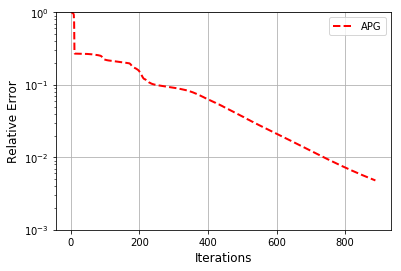

In [17]:
x = np.arange(len(info0['relres2'])) + 1
plt.semilogy(x, info0['relres2'], 'r--', linewidth=2, label='APG')
plt.grid()
plt.xlabel('Iterations', fontsize=12)
plt.legend(loc='upper right')
plt.ylabel('Relative Error', fontsize=12)
plt.ylim(1e-3, 1e0)
#plt.show()

Размерности массива:  (32, 32, 256)
Относительное число ненулевых элементов: 1.00
Относительное число ненулевых элементов: 0.04


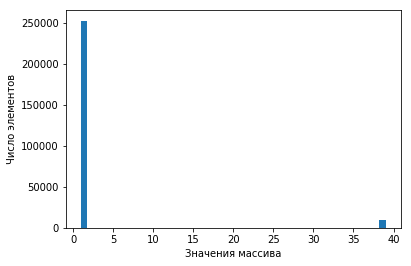

In [8]:
## Загрузка данных из статьи
data_filename = 'Y.mat'
df = loadmat(data_filename)
Y = df['Y']
print "Размерности массива: ", Y.shape

print "Относительное число ненулевых элементов: %.2f" % ((Y>0).sum() / float(Y.size))
plt.hist(Y.flatten(), bins=50, label='raw');
plt.xlabel(u'Значения массива')
plt.ylabel(u'Число элементов')
Y1 = Y - np.min(Y)
print "Относительное число ненулевых элементов: %.2f" % ((Y1>0).sum() / float(Y1.size))

In [23]:
eps = np.spacing(1.)
doHOSVD = True

# dimension of tensor
Nway = Y.shape
# dimension of core tensor
coreNway = [30, 20, 30]

# randomly generate core tensor
A, G = initialize(Nway, coreNway)
# get tensor from loaded data
Mtrue = Y.copy()
#Mtrue /= np.max(Mtrue)
Mtrue = Mtrue / np.linalg.norm(Mtrue)#
N = Mtrue.ndim
Nway = Mtrue.shape
'''
# signal to noise ratio
sn = 60
# -- add noise --
Noise = np.random.normal(size=Nway)
Noise = np.maximum(Noise, 0.)
M = Mtrue + np.power(10, -sn/20.)*np.linalg.norm(Mtrue) / np.linalg.norm(Noise)*Noise
'''
M = Mtrue.copy()
A0, G0 = initialize(Nway, coreNway)
if doHOSVD:
    A0, G0 = hosvd(M, A0, G0, eps)

## Solve problem
opts = {}
opts['maxitnum'] = 10000
opts['tol'] = 1e-7
opts['init'] = {'A': A0, 'G': G0}
opts['margin'] = eps
opts['Gamma'] = np.ones(N+1)
opts['Lambda'] = np.zeros(N+1)
opts['verbose'] = False
#M = Y.copy() / np.linalg.norm(Y)
#Mtrue = M.copy()
t0 = time.clock()
####################################################
A1, G1, info0 = proximalALS(M, coreNway, **opts)
####################################################
t1 = time.clock()

# Reporting
relerr = np.linalg.norm(recover(A1, G1) - Mtrue) / np.linalg.norm(Mtrue)
print 'APG: time = %4.2e, ' % (t1 - t0)
print 'solution relative error = %4.2e\n\n' % (relerr)

APG: time = 1.48e+02, 
solution relative error = 2.94e-03




(0.001, 1.0)

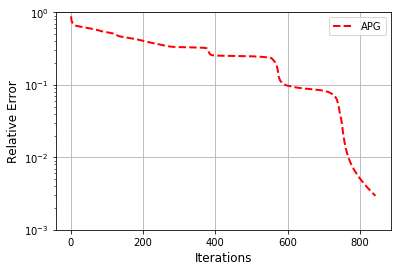

In [24]:
x = np.arange(len(info0['relres2'])) + 1
plt.semilogy(x, info0['relres2'], 'r--', linewidth=2, label='APG')
plt.grid()
plt.xlabel('Iterations', fontsize=12)
plt.legend(loc='upper right')
plt.ylabel('Relative Error', fontsize=12)
plt.ylim(1e-3, 1e0)
#plt.show()

In [43]:
## теперь для разреженных данных

eps = np.spacing(1.)
doHOSVD = True

# dimension of tensor
Nway = Y.shape
# dimension of core tensor
coreNway = [30, 20, 30]

# randomly generate core tensor
A, G = initialize(Nway, coreNway)
# get tensor from loaded data
Mtrue = Y1.copy()
#Mtrue /= np.max(Mtrue)
#Mtrue = Mtrue / np.linalg.norm(Mtrue)#
N = Mtrue.ndim
Nway = Mtrue.shape
'''
# signal to noise ratio
sn = 60
# -- add noise --
Noise = np.random.normal(size=Nway)
Noise = np.maximum(Noise, 0.)
M = Mtrue + np.power(10, -sn/20.)*np.linalg.norm(Mtrue) / np.linalg.norm(Noise)*Noise
'''
M = Mtrue.copy()
A0, G0 = initialize(Nway, coreNway)
if doHOSVD:
    A0, G0 = hosvd(M, A0, G0, eps)

## Solve problem
opts = {}
opts['maxitnum'] = 10000
opts['tol'] = 1e-7
opts['init'] = {'A': A0, 'G': G0}
opts['margin'] = eps
opts['Gamma'] = np.ones(N+1)
opts['Lambda'] = 0.01*np.ones(N+1)
opts['verbose'] = False
#M = Y.copy() / np.linalg.norm(Y)
#Mtrue = M.copy()
t0 = time.clock()
####################################################
A1, G1, info0 = proximalALS(M, coreNway, **opts)
####################################################
t1 = time.clock()

# Reporting
relerr = np.linalg.norm(recover(A1, G1) - Mtrue) / np.linalg.norm(Mtrue)
print 'APG: time = %4.2e, ' % (t1 - t0)
print 'solution relative error = %4.2e\n\n' % (relerr)

APG: time = 2.26e+03, 
solution relative error = 1.12e-01




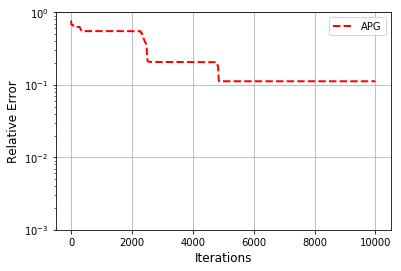

In [44]:
x = np.arange(len(info0['relres2'])) + 1
plt.semilogy(x, info0['relres2'], 'r--', linewidth=2, label='APG')
plt.grid()
plt.xlabel('Iterations', fontsize=12)
plt.legend(loc='upper right')
plt.ylabel('Relative Error', fontsize=12)
plt.ylim(1e-3, 1e0);
#plt.show()

In [ ]:
### черновик